In [6]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

s

In [7]:
from pathlib import Path
from fastai.basic_train import load_learner

In [57]:
model_path = Path("/home/jupyter/models/")
output_path = Path("home/jupyter/data/style_transfers_2/")

In [9]:
learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
cnn = learner.model[0][0]

In [12]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [13]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [17]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [117]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'


#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = Path("/home/jupyter/models/")
style_img = style_img[:, :3, :, :512]



styles = ['hendrix', "kandis", "..."]
content = ["markus", "cesar", "ben"]

#product(styles, content)
batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    "loss_func": "",
    "style_content_pairs": [ #can run multiple pair, inputs
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    "optimizer": "LGTB",
    
    "callback": "...",
    "style_transfer_optim_v": 0.1,
    "style_injects": [[f'conv-{i}' for i in range(15)]],
    "content_injects": [[f'conv-{i}' for i in range(15)]], #doesn't really make a difference
    "epochs": 1000,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weight": 0.05,
    "output_path":"/home/jupyter/data/style_transfers_2/"
    #just sketching the output file here - not config
    #"outputs": [{"epoch": 100, img_path:"..." }]
}


In [98]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

In [107]:
StyleTransferModule??

In [114]:
#add %timer to params -- know how long the training took
from numpy import random
def hyperparam_traverse(config, model_path="/home/jupyter/models/", use_noise=False):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)    

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]
 

    #for loop here over permutations
    for idx, style_inject in enumerate(config["style_injects"]):
        
        style_module = StyleTransferModule(
        arch, 
        content_target=content_img, 
        content_layer_keys=content_injects[0], #TRY AGAIN WITH CONTENT 
        style_target=style_img, 
        style_layer_keys=style_inject)
        
            #TODO try noise instead
         #TODO try noise instead
        if use_noise: 
            input_img = torch.rand(content_img.size()).to(device)
        else:
            input_img = content_img.clone()
        # style_injects = config["style_injects"]
        folder_name = "try"
        for s in style_inject:
            folder_name += "-" + s.split("-")[1]
        folder_name += "/"
        p = Path(outpath + folder_name)
        print(p)
        p.mkdir(parents=True, exist_ok=True)
        conf = config.copy()
        conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
        conf["outputs"] = []

        conf["style_injects"] = style_inject

        def tap_closure(epoch, img, style_loss, content_loss):                
            if epoch % config["save_every_x_epoch"] != 0: 
                return
            image = img.cpu().clone()  # we clone the tensor to not do changes on it
            image = image.squeeze(0)      # remove the fake batch dimension
            image = unloader(image)
            SL = str(round(style_loss))
            CL = str(round(content_loss))
            print("SL:  ", SL, "CL:  ", CL)
            fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
            conf["outputs"].append({"epoch": epoch, "image": fname, "style_loss": SL, "content_loss": CL})
            image.save(p / fname, 'JPEG')

        #print(str(style_inject))
        output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=False)
    
                     
        #SAVE CONFIG
        meta = "config.json"
        filepath = p / meta
        #json.dump(conf, default=lambda o: o.__dict__, indent=4)
        with open(filepath, 'w') as outfile:
            json.dump(conf, outfile)
    
    plt.figure()
    imshow(output, title='Output Image')
    
    return output
    

/home/jupyter/data/style_transfers_2/try-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14
Optimizing...
SL:   2782202 CL:   0
SL:   17417 CL:   2193
SL:   6112 CL:   2253
SL:   16475 CL:   2191
SL:   2653 CL:   2255


tensor([[[[0.8905, 0.9038, 0.8660,  ..., 0.9811, 1.0000, 1.0000],
          [0.9245, 0.9245, 0.9417,  ..., 0.9637, 1.0000, 1.0000],
          [0.9145, 0.9428, 0.9439,  ..., 0.7968, 0.7935, 0.8479],
          ...,
          [0.7737, 0.9183, 0.9303,  ..., 0.8716, 0.8367, 0.7767],
          [0.7527, 0.9050, 0.9182,  ..., 0.8647, 0.8530, 0.8396],
          [0.7466, 0.7466, 0.8083,  ..., 0.8590, 0.8543, 0.8329]],

         [[0.9988, 0.9997, 0.9340,  ..., 0.9999, 1.0000, 0.9994],
          [0.9998, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9958, 0.9812, 0.9704],
          ...,
          [0.5899, 0.8599, 0.9376,  ..., 0.9227, 0.9496, 0.8753],
          [0.5525, 0.7306, 0.8285,  ..., 0.9908, 0.9953, 0.8971],
          [0.4945, 0.5762, 0.6207,  ..., 0.8048, 0.9880, 0.8516]],

         [[0.9164, 0.9461, 0.8938,  ..., 0.9983, 0.9942, 0.9664],
          [0.9690, 0.9676, 0.9078,  ..., 1.0000, 1.0000, 0.9990],
          [0.9585, 0.9674, 0.9094,  ..., 0

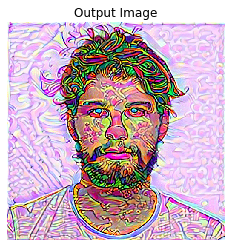

In [115]:
hyperparam_traverse(batch_config)
#

/home/jupyter/data/style_transfers_2/try-0-1-2-3
Optimizing...
SL:   4228211 CL:   722
SL:   19607 CL:   572
SL:   6596 CL:   577
SL:   3296 CL:   578
SL:   2017 CL:   579


tensor([[[[5.1589e-01, 6.1120e-01, 5.4434e-01,  ..., 7.3383e-01,
           7.3544e-01, 4.5236e-01],
          [3.1408e-01, 9.1113e-01, 8.0753e-01,  ..., 9.9961e-01,
           2.1517e-01, 4.6223e-01],
          [1.6012e-01, 9.5520e-01, 7.7765e-01,  ..., 5.4340e-01,
           4.7835e-01, 1.7335e-01],
          ...,
          [5.0569e-01, 2.4755e-01, 2.3379e-01,  ..., 7.5671e-01,
           3.2075e-01, 9.2469e-01],
          [3.2209e-01, 3.5711e-01, 4.6840e-01,  ..., 5.3720e-01,
           9.1182e-01, 4.5767e-01],
          [9.9237e-01, 2.8596e-01, 5.2994e-01,  ..., 3.8723e-01,
           6.9322e-01, 7.1137e-01]],

         [[5.5257e-01, 5.2404e-01, 8.7403e-01,  ..., 2.4240e-01,
           3.9908e-01, 2.9859e-01],
          [8.7233e-01, 5.0109e-01, 3.7353e-01,  ..., 4.4043e-02,
           7.4843e-01, 5.9899e-01],
          [8.5024e-01, 6.6076e-01, 5.0209e-01,  ..., 5.3710e-01,
           4.0885e-01, 8.5555e-01],
          ...,
          [4.3380e-01, 4.3726e-02, 2.7437e-02,  ..., 3.1238

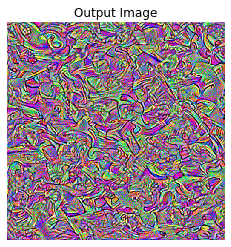

In [91]:
hyperparam_traverse(batch_config, use_noise=True)


In [92]:
from itertools import product, chain, combinations, permutations

In [93]:
from random import sample 
conv_layer_indices = list(range(0, 16))

In [94]:
str(['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15'])

"['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15']"

In [95]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(conv_layer_indices) if subs != ()]
samp = sample(layer_combos,k=30)


samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]


In [96]:
samp_layers

[['conv-1', 'conv-3', 'conv-5', 'conv-7', 'conv-11', 'conv-13'],
 ['conv-2',
  'conv-3',
  'conv-7',
  'conv-8',
  'conv-9',
  'conv-10',
  'conv-11',
  'conv-12',
  'conv-14',
  'conv-15'],
 ['conv-1', 'conv-8', 'conv-10', 'conv-11', 'conv-14', 'conv-15'],
 ['conv-2',
  'conv-5',
  'conv-6',
  'conv-7',
  'conv-8',
  'conv-10',
  'conv-11',
  'conv-15'],
 ['conv-1',
  'conv-5',
  'conv-6',
  'conv-7',
  'conv-8',
  'conv-12',
  'conv-13',
  'conv-14'],
 ['conv-0',
  'conv-1',
  'conv-3',
  'conv-4',
  'conv-5',
  'conv-8',
  'conv-9',
  'conv-10',
  'conv-11',
  'conv-12'],
 ['conv-0',
  'conv-1',
  'conv-2',
  'conv-3',
  'conv-5',
  'conv-6',
  'conv-7',
  'conv-10',
  'conv-12',
  'conv-13'],
 ['conv-0',
  'conv-1',
  'conv-2',
  'conv-3',
  'conv-4',
  'conv-5',
  'conv-6',
  'conv-7',
  'conv-9',
  'conv-10',
  'conv-12',
  'conv-13',
  'conv-14'],
 ['conv-0',
  'conv-1',
  'conv-2',
  'conv-5',
  'conv-8',
  'conv-9',
  'conv-10',
  'conv-11',
  'conv-13'],
 ['conv-0',
  'conv-1

In [118]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
hyperparam_traverse(bc)

/home/jupyter/data/style_transfers_2/try-1-3-5-7-11-13
Optimizing...
SL:   1695615 CL:   0
SL:   15246 CL:   2133
SL:   4217 CL:   2154
SL:   2131 CL:   2128
SL:   1337 CL:   2072
SL:   1154 CL:   2054
SL:   62142 CL:   2264
SL:   3477 CL:   2251
SL:   1372 CL:   2194
SL:   903 CL:   2140
SL:   720 CL:   2093
SL:   657 CL:   2049
SL:   608 CL:   2028
SL:   663 CL:   2021
SL:   560 CL:   1995
SL:   53065 CL:   2335
SL:   4200 CL:   2300
SL:   1585 CL:   2227
SL:   1055 CL:   2164
SL:   714 CL:   2131
SL:   641 CL:   2091
/home/jupyter/data/style_transfers_2/try-2-3-7-8-9-10-11-12-14-15
Optimizing...
SL:   2162244 CL:   0
SL:   16801 CL:   2198
SL:   6709 CL:   2210
SL:   20093 CL:   2666
SL:   5623 CL:   2537
SL:   2300 CL:   2492
SL:   1388 CL:   2447
SL:   1036 CL:   2409
SL:   866 CL:   2386
SL:   762 CL:   2365
SL:   1902 CL:   2315
SL:   767 CL:   2338
SL:   11960 CL:   2261
SL:   20609 CL:   2748
SL:   6420 CL:   2646
SL:   3044 CL:   2616
SL:   1831 CL:   2568
SL:   1181 CL:   25

SL:   11426 CL:   2372
SL:   2911 CL:   2375
SL:   1444 CL:   2365
SL:   2086 CL:   2331
SL:   834 CL:   2327
SL:   768 CL:   2311
SL:   726 CL:   2302
SL:   691 CL:   2292
SL:   671 CL:   2286
SL:   638 CL:   2280
SL:   11920097 CL:   4118
SL:   17176 CL:   2483
SL:   4764 CL:   2484
SL:   2151 CL:   2465
/home/jupyter/data/style_transfers_2/try-0-4-7-8-9-12-13-14
Optimizing...
SL:   2104860 CL:   0
SL:   19981 CL:   2073
SL:   3163 CL:   2165
SL:   1533 CL:   2163
SL:   1100 CL:   2157
SL:   941 CL:   2150
SL:   1134 CL:   2152
SL:   764 CL:   2149
SL:   720 CL:   2136
SL:   707 CL:   2128
SL:   806 CL:   2122
SL:   13408 CL:   2068
SL:   7869 CL:   2355
SL:   1885 CL:   2355
SL:   1054 CL:   2311
SL:   783 CL:   2280
SL:   694 CL:   2256
SL:   653 CL:   2234
SL:   632 CL:   2219
SL:   618 CL:   2208
SL:   619 CL:   2195
/home/jupyter/data/style_transfers_2/try-0-1-4-5-6-7-9-10-11-12-13-14-15
Optimizing...
SL:   2386272 CL:   0
SL:   17908 CL:   2229
SL:   5021 CL:   2281
SL:   3029 

OverflowError: cannot convert float infinity to integer